In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CSV paths
data_path = '/content/drive/My Drive/mimic_iii_data_raw/'
admission_path = data_path + 'ADMISSIONS.csv.gz'
patients_path = data_path + 'PATIENTS.csv.gz'
icu_stays_path = data_path + 'ICUSTAYS.csv.gz'
note_events_path= data_path + 'NOTEEVENTS.csv.gz'
chart_events_path = data_path + 'CHARTEVENTS.csv.gz'

In [ ]:
# Patients data
patients_df = pd.read_csv(patients_path, compression='gzip')
patients_df['DOB'] = pd.to_datetime(patients_df['DOB'])
patients_df = patients_df[['SUBJECT_ID', 'GENDER', 'DOB']]
patients_df.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [ ]:
# Admissions data
admissions_df = pd.read_csv(admission_path, compression='gzip')
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])
admissions_df['DEATHTIME'] = pd.to_datetime(admissions_df['DEATHTIME'])
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
# Merge admissions and patients data
df = pd.merge(admissions_df, patients_df, on='SUBJECT_ID', how='inner')

del admissions_df
del patients_df
gc.collect()


df['AGE'] = (df['ADMITTIME'].dt.year - df['DOB'].dt.year)
df = df[df['AGE'] >= 18]
df = df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

df = df.drop_duplicates(subset=['SUBJECT_ID'], keep='first')
df = df[df['HAS_CHARTEVENTS_DATA'] == 1]
df = df.sample(n=2000, random_state=42)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,GENDER,DOB,AGE
220,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1,F,2128-02-22,50
34891,34309,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,SINGLE,WHITE,NaN,NaN,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,0,1,M,2101-05-27,39
4068,3966,3287,110985,2150-05-12 19:11:00,2150-06-09 05:10:00,2150-06-09 05:10:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,DIABETES MELLITUS;HIP FRACTURE;DECUBITIS ULCER,1,1,F,2072-04-21,78
55355,55224,88343,127280,2154-12-03 16:33:00,2154-12-11 13:25:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,REHAB/DISTINCT PART HOSP,Medicare,...,MARRIED,WHITE,2154-12-03 14:59:00,2154-12-03 17:29:00,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,0,1,M,2073-08-30,81
54604,55511,89236,131839,2149-12-10 00:10:00,2149-12-15 20:57:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,...,WIDOWED,WHITE,2149-12-09 20:27:00,2149-12-10 01:31:00,URINARY TRACT INFECTION,0,1,F,2067-12-11,82


In [ ]:
# Drop unnecessary columns
df['IN_HOSPITAL_MORTALITY'] = df['HOSPITAL_EXPIRE_FLAG']
df = df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'DIAGNOSIS', 'AGE', 'GENDER', 'IN_HOSPITAL_MORTALITY']]
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,AGE,GENDER,IN_HOSPITAL_MORTALITY
220,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,BRAIN MASS,50,F,0
34891,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0
4068,3287,110985,2150-05-12 19:11:00,2150-06-09 05:10:00,2150-06-09 05:10:00,EMERGENCY,DIABETES MELLITUS;HIP FRACTURE;DECUBITIS ULCER,78,F,1
55355,88343,127280,2154-12-03 16:33:00,2154-12-11 13:25:00,NaT,EMERGENCY,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,81,M,0
54604,89236,131839,2149-12-10 00:10:00,2149-12-15 20:57:00,NaT,EMERGENCY,URINARY TRACT INFECTION,82,F,0


In [ ]:
# ICU data
icustays_df = pd.read_csv(icu_stays_path, compression='gzip')
icustays_df['INTIME'] = pd.to_datetime(icustays_df['INTIME'])
icustays_df['OUTTIME'] = pd.to_datetime(icustays_df['OUTTIME'])
icustays_df

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202
...,...,...,...,...,...,...,...,...,...,...,...,...
61527,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.1894
61528,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.4942
61529,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.9259
61530,59809,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.3346


In [ ]:
# Clean ICU data
cohort_icustays = pd.merge(icustays_df, df[['HADM_ID']], on=['HADM_ID'], how='inner')
del icustays_df
gc.collect()
cohort_icustays = cohort_icustays.sort_values(by=['HADM_ID', 'INTIME'])

first_icustays = cohort_icustays.drop_duplicates(subset=['HADM_ID'], keep='first')
first_icustays = first_icustays[['HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS', 'FIRST_CAREUNIT']]
first_icustays

,HADM_ID,ICUSTAY_ID,INTIME,OUTTIME,LOS,FIRST_CAREUNIT
1844,100075,278942,2186-02-01 17:02:13,2186-02-02 13:00:53,0.8324,SICU
1362,100085,241237,2126-08-30 14:04:01,2126-08-31 17:25:41,1.1400,TSICU
1717,100094,243139,2109-06-06 10:21:45,2109-06-07 12:07:39,1.0735,CCU
928,100108,273316,2143-04-29 23:28:39,2143-05-12 18:19:27,12.7853,MICU
1065,100137,212691,2115-01-12 23:14:06,2115-01-16 16:44:52,3.7297,CCU
...,...,...,...,...,...,...
1874,199786,238481,2119-03-04 18:43:14,2119-03-05 09:49:16,0.6292,MICU
62,199833,212452,2126-11-04 06:32:03,2126-11-05 18:27:10,1.4966,MICU
284,199864,258616,2192-04-06 11:33:16,2192-04-08 21:19:53,2.4074,TSICU
138,199943,227097,2194-02-04 12:36:28,2194-02-06 04:02:09,1.6428,MICU


In [ ]:
# Merge ICU data
df = pd.merge(df, first_icustays, on=['HADM_ID'], how='inner')
del first_icustays
gc.collect()
df

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,AGE,GENDER,IN_HOSPITAL_MORTALITY,ICUSTAY_ID,INTIME,OUTTIME,LOS,FIRST_CAREUNIT
0,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,BRAIN MASS,50,F,0,229441,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,SICU
1,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU
2,3287,110985,2150-05-12 19:11:00,2150-06-09 05:10:00,2150-06-09 05:10:00,EMERGENCY,DIABETES MELLITUS;HIP FRACTURE;DECUBITIS ULCER,78,F,1,237825,2150-05-18 15:30:11,2150-05-22 12:29:55,3.8748,CCU
3,88343,127280,2154-12-03 16:33:00,2154-12-11 13:25:00,NaT,EMERGENCY,STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,81,M,0,208762,2154-12-03 16:33:53,2154-12-04 21:24:15,1.2016,SICU
4,89236,131839,2149-12-10 00:10:00,2149-12-15 20:57:00,NaT,EMERGENCY,URINARY TRACT INFECTION,82,F,0,213252,2149-12-10 00:11:27,2149-12-11 07:08:26,1.2896,MICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992,11544,156336,2107-09-25 23:23:00,2107-09-30 16:30:00,NaT,EMERGENCY,SEPSIS,80,M,0,278755,2107-09-25 23:24:16,2107-09-30 17:27:33,4.7523,MICU
1993,54188,132582,2141-02-02 22:12:00,2141-03-09 18:23:00,NaT,EMERGENCY,BOWEL PERFORATION,62,M,0,269408,2141-02-03 03:04:36,2141-02-27 17:22:38,24.5959,SICU
1994,51428,110617,2159-10-10 08:00:00,2159-10-14 13:30:00,NaT,ELECTIVE,AORTIC VALVE INSUFFICIENCY\AORTIC VALVE / ASCE...,61,M,0,203881,2159-10-10 14:33:07,2159-10-11 20:53:28,1.2641,CSRU
1995,2610,114792,2110-11-14 19:06:00,2110-11-26 11:30:00,NaT,EMERGENCY,ACUTE MYOCARDIAL INFARCTION,81,F,0,288031,2110-11-14 19:07:37,2110-11-17 15:23:32,2.8444,CCU


In [ ]:
# Process part of the chart events data
def load_chartevents_for_cohort(chart_events_path, cohort_icustay_ids, max_chunks=1, chunk_size=5000000):
    cohort_ids = set(cohort_icustay_ids)
    filtered_chartevents = []

    columns_to_read = ['ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUE', 'VALUENUM', 'VALUEUOM']

    chartevents_reader = pd.read_csv(
        chart_events_path,
        compression='gzip',
        usecols=columns_to_read,
        chunksize=chunk_size,
        nrows=chunk_size * max_chunks
    )

    for chunk_idx, chunk in enumerate(chartevents_reader, 1):
        start_row = (chunk_idx - 1) * chunk_size + 1
        end_row = chunk_idx * chunk_size
        print(f"  Processing chartevents chunk {chunk_idx} (rows {start_row} to {end_row})...")

        relevant_records = chunk[chunk['ICUSTAY_ID'].isin(cohort_ids)]

        if not relevant_records.empty:
            filtered_chartevents.append(relevant_records)

        if chunk_idx >= max_chunks:
            print(f"  Stopped reading CHARTEVENTS after {max_chunks} chunk(s).")
            break

    del chartevents_reader
    gc.collect()

    return filtered_chartevents

In [ ]:
cohort_icustay_ids = df['ICUSTAY_ID'].unique()
raw_chartevents_for_cohort = load_chartevents_for_cohort(chart_events_path, cohort_icustay_ids)

  Processing chartevents chunk 1 (rows 1 to 5000000)...
  Stopped reading CHARTEVENTS after 1 chunk(s).


In [ ]:
all_raw_events_df = pd.concat(raw_chartevents_for_cohort, ignore_index=True)
all_raw_events_df["ICUSTAY_ID"] = all_raw_events_df["ICUSTAY_ID"].astype(int)
all_raw_events_df

,ICUSTAY_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM
0,238507,220046,2162-05-27 20:00:00,120.0,120.0,bpm
1,238507,220047,2162-05-27 20:00:00,60.0,60.0,bpm
2,238507,223751,2162-05-27 20:00:00,160.0,160.0,mmHg
3,238507,223752,2162-05-27 20:00:00,90.0,90.0,mmHg
4,238507,223761,2162-05-27 20:00:00,99.4,99.4,?F
...,...,...,...,...,...,...
43276,290577,224684,2158-05-08 12:00:00,600.0,600.0,mL
43277,290577,224685,2158-05-08 12:00:00,303.0,303.0,mL
43278,290577,224687,2158-05-08 12:00:00,19.9,19.9,L/min
43279,290577,224688,2158-05-08 12:00:00,18.0,18.0,insp/min


In [ ]:
# Merge chart events data
df = pd.merge(df, all_raw_events_df, on='ICUSTAY_ID', how='inner')
del all_raw_events_df
del raw_chartevents_for_cohort
gc.collect()
df

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,AGE,GENDER,IN_HOSPITAL_MORTALITY,ICUSTAY_ID,INTIME,OUTTIME,LOS,FIRST_CAREUNIT,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM
0,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,225624,2140-04-13 02:43:00,15.00,15.00,mg/dL
1,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227073,2140-04-13 02:43:00,13.00,13.00,mEq/L
2,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227442,2140-04-13 02:43:00,4.60,4.60,mEq/L
3,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227443,2140-04-13 02:43:00,23.00,23.00,mEq/L
4,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,217444,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,220224,2140-04-12 10:14:00,383.00,383.00,mmHg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43276,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,244124,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,226537,2120-08-15 03:24:00,120.00,120.00,mg/dL
43277,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,244124,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,223830,2120-08-15 10:25:00,7.47,7.47,units
43278,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,244124,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,225667,2120-08-15 10:25:00,1.08,1.08,mmol/L
43279,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,244124,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,226537,2120-08-15 10:25:00,166.00,166.00,mg/dL


In [ ]:
def load_noteevents_for_cohort(note_events_path, cohort_hadm_ids, max_chunks=1, chunk_size=500000):
    cohort_ids = set(cohort_hadm_ids)
    filtered_noteevents = []

    columns_to_read = [
        'ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
        'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'
    ]

    noteevents_reader = pd.read_csv(
        note_events_path,
        compression='gzip',
        usecols=columns_to_read,
        chunksize=chunk_size,
        nrows=chunk_size * max_chunks
    )

    for chunk_idx, chunk in enumerate(noteevents_reader, 1):
        start_row = (chunk_idx - 1) * chunk_size + 1
        end_row = chunk_idx * chunk_size
        print(f"  Processing noteevents chunk {chunk_idx} (rows {start_row} to {end_row})...")

        relevant_notes = chunk[chunk['HADM_ID'].isin(cohort_ids)]

        if not relevant_notes.empty:
            filtered_noteevents.append(relevant_notes)

        if chunk_idx >= max_chunks:
            print(f"  Stopped reading NOTEEVENTS after {max_chunks} chunk(s).")
            break

    del noteevents_reader
    gc.collect()

    return filtered_noteevents

In [ ]:
cohort_hadm_ids = df['HADM_ID'].unique()
raw_noteevents_for_cohort = load_noteevents_for_cohort(note_events_path, cohort_hadm_ids)

<ipython-input-15-1ddfe018a0bf>:18: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_idx, chunk in enumerate(noteevents_reader, 1):


  Processing noteevents chunk 1 (rows 1 to 500000)...
  Stopped reading NOTEEVENTS after 1 chunk(s).


In [ ]:
all_raw_notes_df = pd.concat(raw_noteevents_for_cohort, ignore_index=True)
all_raw_notes_df["HADM_ID"] = all_raw_notes_df["HADM_ID"].astype(int)
all_raw_notes_df = all_raw_notes_df[["HADM_ID", "CHARTDATE", "CATEGORY", "DESCRIPTION", "TEXT"]]

In [ ]:
# Merge note events data
notes_combined = all_raw_notes_df.groupby('HADM_ID').agg({
    'TEXT': lambda x: ' '.join(str(text) for text in x if pd.notna(text))
}).reset_index()
df_merged = pd.merge(df, notes_combined, on='HADM_ID', how='inner')
df_merged

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,DIAGNOSIS,AGE,GENDER,IN_HOSPITAL_MORTALITY,...,INTIME,OUTTIME,LOS,FIRST_CAREUNIT,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,TEXT
0,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,...,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,225624,2140-04-13 02:43:00,15.00,15.00,mg/dL,Admission Date: [**2140-4-11**] ...
1,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,...,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227073,2140-04-13 02:43:00,13.00,13.00,mEq/L,Admission Date: [**2140-4-11**] ...
2,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,...,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227442,2140-04-13 02:43:00,4.60,4.60,mEq/L,Admission Date: [**2140-4-11**] ...
3,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,...,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,227443,2140-04-13 02:43:00,23.00,23.00,mEq/L,Admission Date: [**2140-4-11**] ...
4,28077,171916,2140-04-11 10:45:00,2140-05-03 20:00:00,NaT,ELECTIVE,MITRAL VALVE INSUFFIENCY\MITRAL VALVE REPLACEM...,39,M,0,...,2140-04-12 09:52:37,2140-04-13 18:52:25,1.3749,CSRU,220224,2140-04-12 10:14:00,383.00,383.00,mmHg,Admission Date: [**2140-4-11**] ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43188,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,...,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,226537,2120-08-15 03:24:00,120.00,120.00,mg/dL,Admission Date: [**2120-8-14**] ...
43189,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,...,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,223830,2120-08-15 10:25:00,7.47,7.47,units,Admission Date: [**2120-8-14**] ...
43190,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,...,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,225667,2120-08-15 10:25:00,1.08,1.08,mmol/L,Admission Date: [**2120-8-14**] ...
43191,27590,104467,2120-08-14 07:15:00,2120-08-18 16:06:00,NaT,ELECTIVE,CORONARY DISEASE\CORONARY ARTERY BYPASS GRAFT ...,74,M,0,...,2120-08-14 11:32:53,2120-08-15 16:33:47,1.2090,CSRU,226537,2120-08-15 10:25:00,166.00,166.00,mg/dL,Admission Date: [**2120-8-14**] ...


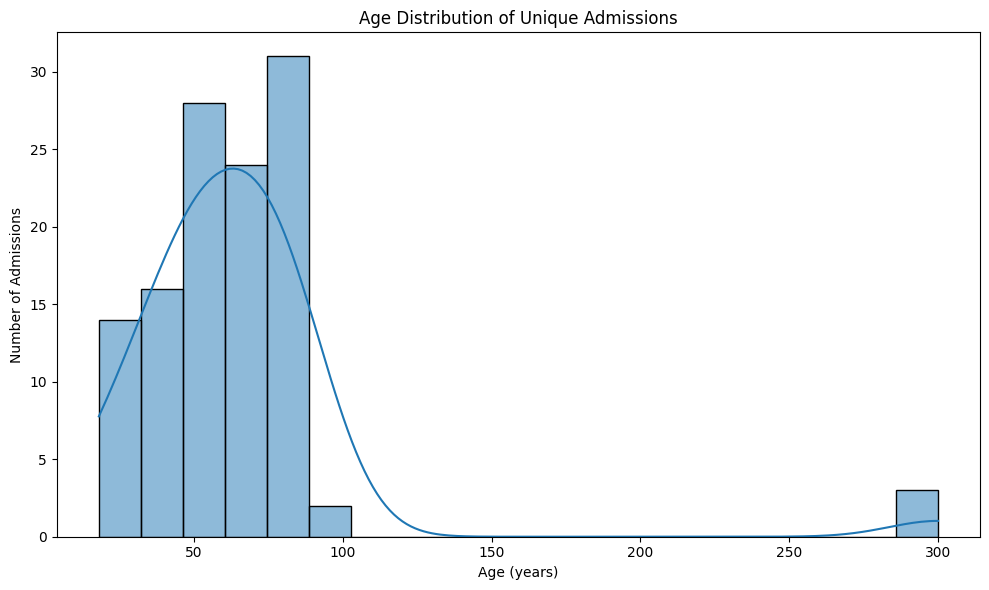

In [ ]:
# Create histogram of age distribution for unique admissions
plt.figure(figsize=(10, 6))
unique_admissions = df.drop_duplicates(subset=['HADM_ID'])
sns.histplot(data=unique_admissions, x='AGE', kde=True, bins=20)
plt.title('Age Distribution of Unique Admissions')
plt.xlabel('Age (years)')
plt.ylabel('Number of Admissions')
plt.tight_layout()
plt.show()

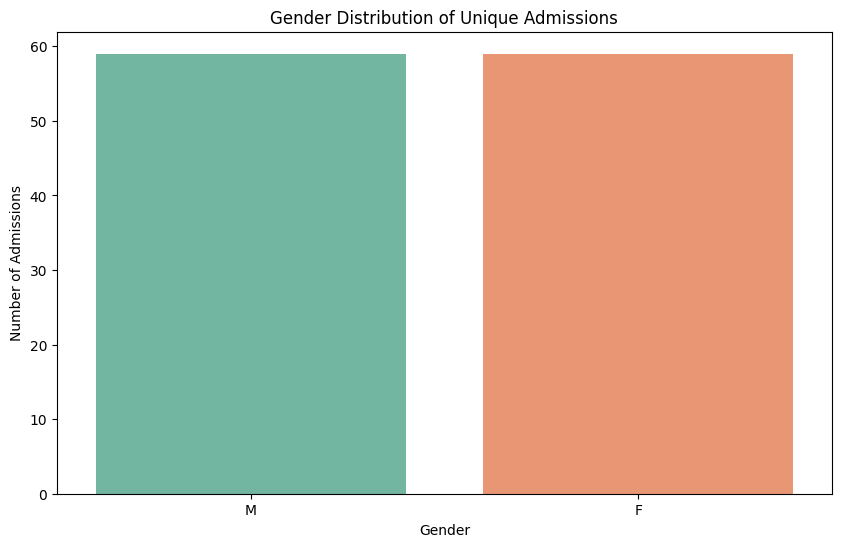

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='GENDER', data=unique_admissions, palette="Set2", hue='GENDER')
plt.title('Gender Distribution of Unique Admissions')
plt.xlabel('Gender')
plt.ylabel('Number of Admissions')
plt.show()

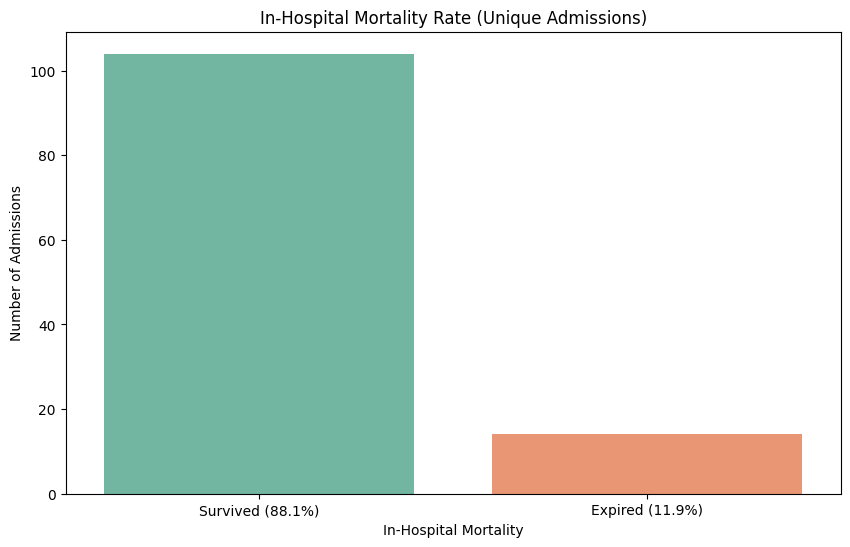

In [ ]:
plt.figure(figsize=(10, 6))
mortality_counts = unique_admissions['IN_HOSPITAL_MORTALITY'].value_counts(normalize=True) * 100
sns.countplot(x='IN_HOSPITAL_MORTALITY', data=unique_admissions, palette='Set2', hue='IN_HOSPITAL_MORTALITY', legend=False)
plt.title('In-Hospital Mortality Rate (Unique Admissions)')
plt.xlabel('In-Hospital Mortality')
plt.ylabel('Number of Admissions')
labels = [f'Survived ({mortality_counts.get(0,0):.1f}%)',
          f'Expired ({mortality_counts.get(1,0):.1f}%)']
plt.xticks([0, 1], labels)
plt.show()

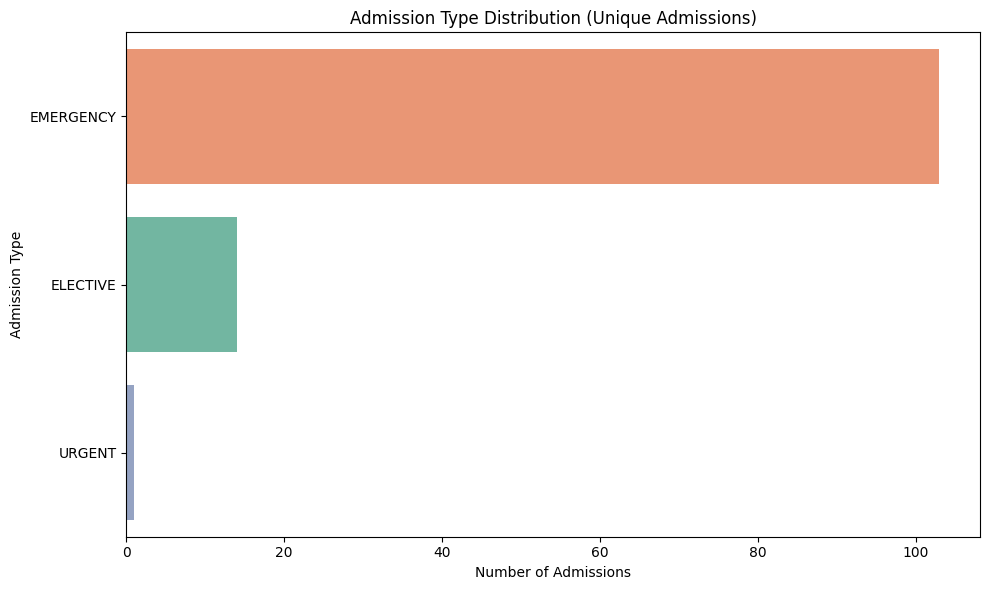

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='ADMISSION_TYPE', data=unique_admissions, order=unique_admissions['ADMISSION_TYPE'].value_counts().index, palette="Set2", hue="ADMISSION_TYPE")
plt.title('Admission Type Distribution (Unique Admissions)')
plt.xlabel('Number of Admissions')
plt.ylabel('Admission Type')
plt.tight_layout()
plt.show()

In [ ]:
numeric_cols_admissions = ['AGE', 'LOS']
print(unique_admissions[numeric_cols_admissions].describe().T)

     count       mean        std      min      25%      50%       75%  \
AGE  118.0  65.152542  42.856873  18.0000  46.2500  61.0000  77.75000   
LOS  118.0   3.705637   4.237369   0.3108   1.3274   2.0087   4.16675   

          max  
AGE  300.0000  
LOS   25.8728  


In [ ]:
print(pd.crosstab(unique_admissions['ADMISSION_TYPE'], unique_admissions['IN_HOSPITAL_MORTALITY'], margins=True, margins_name="Total"))

IN_HOSPITAL_MORTALITY    0   1  Total
ADMISSION_TYPE                       
ELECTIVE                14   0     14
EMERGENCY               89  14    103
URGENT                   1   0      1
Total                  104  14    118


In [ ]:
del unique_admissions
gc.collect()

9046

In [ ]:
df_final = df_merged.groupby('ICUSTAY_ID').agg({
    'VALUENUM': 'mean',
    'TEXT': 'first',
    'IN_HOSPITAL_MORTALITY': 'first'
}).reset_index()
df_final = df_final.dropna(subset=['VALUENUM', 'TEXT', 'IN_HOSPITAL_MORTALITY'])
df_final

,ICUSTAY_ID,VALUENUM,TEXT,IN_HOSPITAL_MORTALITY
0,204252,66.974638,Admission Date: [**2173-4-24**] ...,0
1,205688,42.952041,Admission Date: [**2112-5-6**] D...,0
2,206490,59.297467,Sinus rhythm. The P waves are peaked and the ...,0
3,207502,48.139660,Admission Date: [**2108-1-1**] D...,0
4,208106,46.831979,Admission Date: [**2193-6-18**] ...,0
...,...,...,...,...
112,296065,42.878431,Admission Date: [**2151-7-25**] ...,0
113,297921,79.423219,Admission Date: [**2126-12-4**] ...,1
114,298536,43.681500,Admission Date: [**2140-3-18**] ...,0
115,298878,85.944000,Admission Date: [**2143-7-22**] ...,1


In [ ]:
X_train, X_test = train_test_split(df_final, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train['VALUENUM'] = scaler.fit_transform(X_train[['VALUENUM']])
X_test['VALUENUM'] = scaler.transform(X_test[['VALUENUM']])

In [ ]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_char_limit = max_length * 10

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        measurements = torch.tensor([row['VALUENUM']], dtype=torch.float32)
        text = str(row['TEXT'])[:self.text_char_limit]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        label = torch.tensor(row['IN_HOSPITAL_MORTALITY'], dtype=torch.float32)

        return {
            'measurements': measurements,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': label
        }


In [ ]:
class MeasurementEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim=32, freeze_bert=True):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.projection = nn.Linear(768, hidden_dim)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = bert_output.last_hidden_state[:, 0, :]
        return self.projection(cls_token)

In [ ]:
class MultimodalModel(nn.Module):
    def __init__(self, measurement_dim=1, hidden_dim=32):
        super(MultimodalModel, self).__init__()

        self.measurement_encoder = MeasurementEncoder(measurement_dim, hidden_dim)
        self.text_encoder = TextEncoder(hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, measurements, input_ids, attention_mask):
        measurement_features = self.measurement_encoder(measurements)
        text_features = self.text_encoder(input_ids, attention_mask)

        combined_features = torch.cat([measurement_features, text_features], dim=1)

        return self.classifier(combined_features)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = MultimodalDataset(
    dataframe=X_train,
    tokenizer=tokenizer,
    max_length=64
)

test_dataset = MultimodalDataset(
    dataframe=X_test,
    tokenizer=tokenizer,
    max_length=64
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=False
)

model = MultimodalModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(
    params=model.parameters(),
    lr=1e-4,
    weight_decay=1e-5
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch in train_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label'].unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(measurements, input_ids, attention_mask)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

    return model


In [ ]:
model = train_model(model, train_loader, criterion, optimizer, 10)
torch.save(model.state_dict(), 'multimodal_model.pt')

Epoch 1, Loss: 0.4698
Epoch 2, Loss: 0.3377
Epoch 3, Loss: 0.3257
Epoch 4, Loss: 0.3072
Epoch 5, Loss: 0.3112
Epoch 6, Loss: 0.3122
Epoch 7, Loss: 0.3159
Epoch 8, Loss: 0.2955
Epoch 9, Loss: 0.3081
Epoch 10, Loss: 0.2942


In [ ]:
def evaluate_saved_model(model_path, test_dataset, batch_size=2):
    model = MultimodalModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label'].unsqueeze(1)

            outputs = model(measurements, input_ids, attention_mask)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    metrics = {
        'auc_roc': roc_auc_score(all_labels, all_preds),
        'auc_pr': average_precision_score(all_labels, all_preds),
        'predictions': all_preds,
        'labels': all_labels
    }

    return metrics

In [ ]:
def zero_shot_evaluation_saved(model_path, test_dataset, tokenizer):
    model = MultimodalModel()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    phrases = {
        "positive": "patient deceased",
        "negative": "discharged today"
    }

    encodings = {}
    for key, phrase in phrases.items():
        encodings[key] = tokenizer(
            phrase,
            max_length=64,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    all_preds, all_labels = [], []

    with torch.no_grad():
        text_encoder = model.text_encoder
        pos_emb = text_encoder(encodings["positive"]['input_ids'],
                              encodings["positive"]['attention_mask'])
        neg_emb = text_encoder(encodings["negative"]['input_ids'],
                              encodings["negative"]['attention_mask'])

        for batch in test_loader:
            measurements = batch['measurements']
            labels = batch['label']

            meas_emb = model.measurement_encoder(measurements)

            pos_sim = torch.nn.functional.cosine_similarity(
                meas_emb, pos_emb.expand(meas_emb.size(0), -1), dim=1)
            neg_sim = torch.nn.functional.cosine_similarity(
                meas_emb, neg_emb.expand(meas_emb.size(0), -1), dim=1)

            probs = torch.nn.functional.softmax(
                torch.stack([neg_sim, pos_sim], dim=1), dim=1)

            all_preds.extend(probs[:, 1].cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        'auc_roc': roc_auc_score(all_labels, all_preds),
        'auc_pr': average_precision_score(all_labels, all_preds),
        'predictions': all_preds,
        'labels': all_labels
    }

    return metrics


In [ ]:
def plot_curves(results):
    from sklearn.metrics import roc_curve, precision_recall_curve
    import matplotlib.pyplot as plt

    y_pred = results['predictions']
    y_true = results['labels']

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(fpr, tpr, label=f'AUC-ROC = {results["auc_roc"]:.4f}')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    axes[1].plot(recall, precision, label=f'AUC-PR = {results["auc_pr"]:.4f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
def compare_with_paper(our_results):
    paper_results = {
        'supervised': {'auc_roc': 0.856, 'auc_roc_std': 0.004, 'auc_pr': 0.495, 'auc_pr_std': 0.005},
        'zero_shot': {'auc_roc': 0.709, 'auc_pr': 0.214}
    }

    print("| Evaluation | AUC-ROC | Paper AUC-ROC | AUC-PR | Paper AUC-PR |")
    print("|------------|---------|---------------|--------|-------------|")

    for eval_type in ['supervised', 'zero_shot']:
        display_name = "Supervised" if eval_type == 'supervised' else "Zero-shot"

        our_roc = our_results[eval_type]['auc_roc']
        our_pr = our_results[eval_type]['auc_pr']
        paper_roc = paper_results[eval_type]['auc_roc']
        paper_pr = paper_results[eval_type]['auc_pr']

        print(f"| {display_name:<11} | {our_roc:.4f} | {paper_roc:.4f} | {our_pr:.4f} | {paper_pr:.4f} |")

    sup_roc_diff = (our_results['supervised']['auc_roc'] - paper_results['supervised']['auc_roc']) / paper_results['supervised']['auc_roc'] * 100
    sup_pr_diff = (our_results['supervised']['auc_pr'] - paper_results['supervised']['auc_pr']) / paper_results['supervised']['auc_pr'] * 100
    zero_roc_diff = (our_results['zero_shot']['auc_roc'] - paper_results['zero_shot']['auc_roc']) / paper_results['zero_shot']['auc_roc'] * 100
    zero_pr_diff = (our_results['zero_shot']['auc_pr'] - paper_results['zero_shot']['auc_pr']) / paper_results['zero_shot']['auc_pr'] * 100


In [ ]:
def evaluate_model_performance():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    test_dataset = MultimodalDataset(X_test, tokenizer, max_length=64)
    model_path = 'multimodal_model.pt'

    supervised_results = evaluate_saved_model(model_path, test_dataset)
    plot_curves(supervised_results)

    zero_shot_results = zero_shot_evaluation_saved(model_path, test_dataset, tokenizer)
    results = {
        'supervised': supervised_results,
        'zero_shot': zero_shot_results
    }

    compare_with_paper(results)
    return results

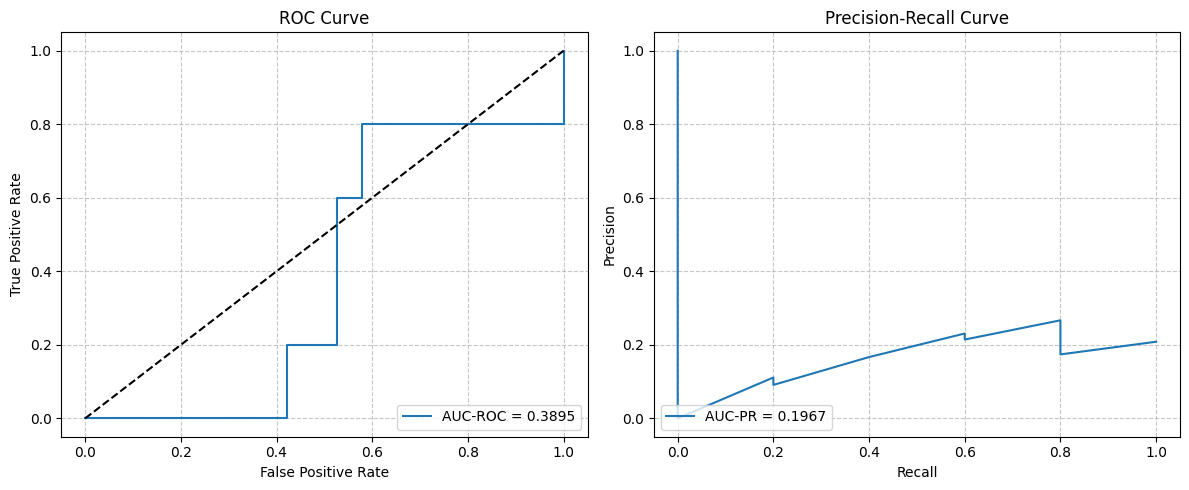

| Evaluation | AUC-ROC | Paper AUC-ROC | AUC-PR | Paper AUC-PR |
|------------|---------|---------------|--------|-------------|
| Supervised  | 0.3895 | 0.8560 | 0.1967 | 0.4950 |
| Zero-shot   | 0.6842 | 0.7090 | 0.5804 | 0.2140 |


In [ ]:
results = evaluate_model_performance()

In [ ]:
class MultimodalModelWithDropout(nn.Module):
    def __init__(self, measurement_dim=1, hidden_dim=32, dropout_prob=0.5):
        super().__init__()
        self.measurement_encoder = MeasurementEncoder(measurement_dim, hidden_dim)
        self.text_encoder = TextEncoder(hidden_dim)
        self.classifier = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

        self.dropout_prob = dropout_prob

        self.missing_measurement_token = nn.Parameter(torch.randn(hidden_dim))
        self.missing_text_token = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, measurements, input_ids, attention_mask, training=True):
        drop_measurement = False
        drop_text = False

        if training:
            drop_measurement = torch.rand(1).item() < self.dropout_prob
            drop_text = torch.rand(1).item() < self.dropout_prob

            if drop_measurement and drop_text:
                drop_measurement = torch.rand(1).item() < 0.5
                drop_text = not drop_measurement

        batch_size = measurements.size(0)

        measurement_emb = (
            self.missing_measurement_token.expand(batch_size, -1)
            if drop_measurement
            else self.measurement_encoder(measurements)
        )

        text_emb = (
            self.missing_text_token.expand(batch_size, -1)
            if drop_text
            else self.text_encoder(input_ids, attention_mask)
        )

        combined = torch.cat([measurement_emb, text_emb], dim=1)
        return self.sigmoid(self.classifier(combined))

In [ ]:
def train_model_with_dropout(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    history = {'loss': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label'].unsqueeze(1)

            optimizer.zero_grad()

            outputs = model(measurements, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['loss'].append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, history


In [ ]:
def evaluate_modality_settings(model, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
    results = {}

    model.eval()

    # Evaluate with both modalities
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label'].unsqueeze(1)

            outputs = model(measurements, input_ids, attention_mask, training=False)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    roc = roc_auc_score(all_labels, all_preds)
    pr = average_precision_score(all_labels, all_preds)

    results['both'] = {'auc_roc': roc, 'auc_pr': pr}
    print(f"Both modalities - AUC-ROC: {roc:.4f}, AUC-PR: {pr:.4f}")

    # Evaluate with only measurements
    print("\nEvaluating with only measurements...")
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            labels = batch['label'].unsqueeze(1)

            batch_size = input_ids.size(0)
            text_emb = model.missing_text_token.expand(batch_size, -1)
            measurement_emb = model.measurement_encoder(measurements)

            combined = torch.cat([measurement_emb, text_emb], dim=1)
            output = model.sigmoid(model.classifier(combined))

            all_preds.extend(output.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    roc = roc_auc_score(all_labels, all_preds)
    pr = average_precision_score(all_labels, all_preds)

    results['measurements_only'] = {'auc_roc': roc, 'auc_pr': pr}
    print(f"Measurements only - AUC-ROC: {roc:.4f}, AUC-PR: {pr:.4f}")

    # Evaluate with only text
    print("\nEvaluating with only text...")
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label'].unsqueeze(1)

            batch_size = measurements.size(0)
            measurement_emb = model.missing_measurement_token.expand(batch_size, -1)
            text_emb = model.text_encoder(input_ids, attention_mask)

            combined = torch.cat([measurement_emb, text_emb], dim=1)
            output = model.sigmoid(model.classifier(combined))

            all_preds.extend(output.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    roc = roc_auc_score(all_labels, all_preds)
    pr = average_precision_score(all_labels, all_preds)

    results['text_only'] = {'auc_roc': roc, 'auc_pr': pr}
    print(f"Text only - AUC-ROC: {roc:.4f}, AUC-PR: {pr:.4f}")

    return results

In [ ]:
def plot_modality_comparison(results):
    settings = ['both', 'measurements_only', 'text_only']
    settings_labels = ['Both Modalities', 'Measurements Only', 'Text Only']

    roc_values = [results[s]['auc_roc'] for s in settings]
    pr_values = [results[s]['auc_pr'] for s in settings]

    x = np.arange(len(settings))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, roc_values, width, label='AUC-ROC')
    rects2 = ax.bar(x + width/2, pr_values, width, label='AUC-PR')

    ax.set_ylabel('Score')
    ax.set_title('Performance by Modality Setting')
    ax.set_xticks(x)
    ax.set_xticklabels(settings_labels)
    ax.legend()

    for rects in (rects1, rects2):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

In [ ]:
def run_modality_dropout_extension():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = MultimodalDataset(X_train, tokenizer, max_length=64)
    test_dataset = MultimodalDataset(X_test, tokenizer, max_length=64)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    model = MultimodalModelWithDropout(dropout_prob=0.3)

    original_model = MultimodalModel()
    original_model.load_state_dict(torch.load('multimodal_model.pt'))

    for target, source in zip([model.measurement_encoder, model.text_encoder],
                             [original_model.measurement_encoder, original_model.text_encoder]):
        target.load_state_dict(source.state_dict())

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    model, history = train_model_with_dropout(model, train_loader, criterion,
                                             optimizer, num_epochs=5)

    torch.save(model.state_dict(), 'multimodal_model_with_dropout.pt')

    modality_results = evaluate_modality_settings(model, test_dataset)
    plot_modality_comparison(modality_results)

    return modality_results


Epoch 1/5, Loss: 0.4880
Epoch 2/5, Loss: 0.3864
Epoch 3/5, Loss: 0.4714
Epoch 4/5, Loss: 0.3916
Epoch 5/5, Loss: 0.3363
Both modalities - AUC-ROC: 0.4000, AUC-PR: 0.1992

Evaluating with only measurements...
Measurements only - AUC-ROC: 0.4947, AUC-PR: 0.4598

Evaluating with only text...
Text only - AUC-ROC: 0.4000, AUC-PR: 0.1955


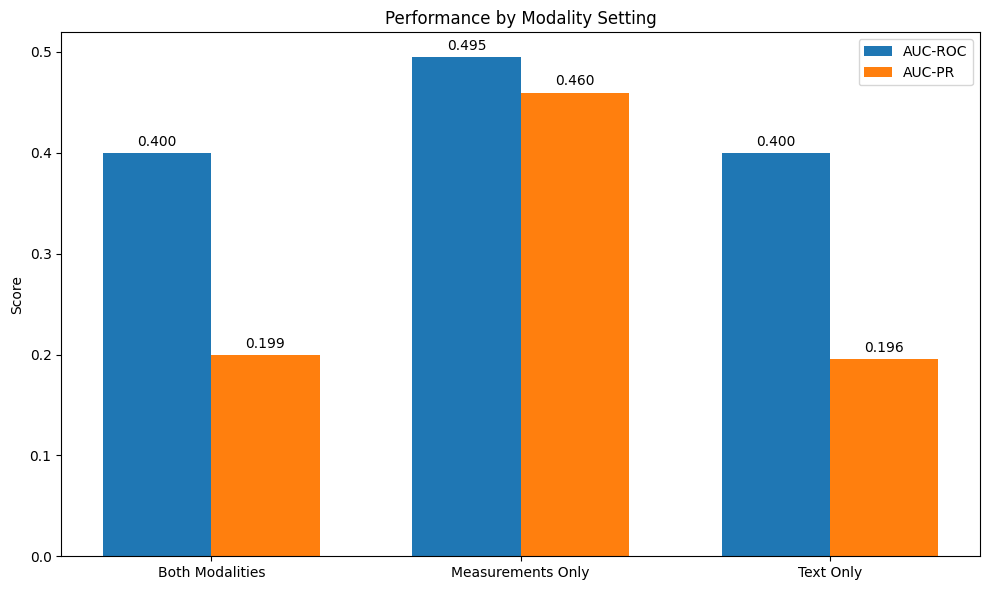

In [ ]:
modality_dropout_results = run_modality_dropout_extension()